# 验证站点数据

# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from Preprocessing import random_spatial_sequence, collate_insitu_validation

C:\Users\jianer\anaconda3\envs\datamining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some Utility Functions

In [3]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'test_ratio': 0.2,
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'train_batch_size': 1, 
    'valid_batch_size': 1,
    'test_batch_size': 1,
    'data_loader': 'total',
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\SE',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\SE\\OUTPUT\\MODELS\\CNN_FROM_UPSCALING'
}

In [5]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [6]:
print(config['root'])
# 创建数据集
insitu_dataset = SMAPDataset(config['root'], insitu_validation=True)
# 创建数据加载器
total_loader = DataLoader(insitu_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE
***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015104\15.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015104\17.npy
D:\1GRADUATE

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\INSITU\2015226\30.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SM\2015226\22.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\INSITU\2015226\22.npy
_____________________________smap cell: 9_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015226\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015226\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015226\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015226\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015226

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015330\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\TEXTURE\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\NDVI\GRID\2015330\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SMAP\2015330\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015330\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\SM\2015330\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\INSITU\2015330\27.npy
_____________________________smap cell: 26_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\LABEL\ATI\GRID_70\2015330\26.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SE\INPUT\SMAP\2015330

In [7]:
print(len(insitu_dataset))

357


In [8]:
# 计算训练集和测试集的长度
train_len = int(len(insitu_dataset) * (1-config['test_ratio']))
test_len = len(insitu_dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(insitu_dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 228
validing size 57
testing size 72


In [9]:
loaders = {}
loaders['train'] = train_loader
loaders['valid'] = valid_loader
loaders['test'] = test_loader
loaders['total'] = total_loader
data_loader = loaders[config['data_loader']]

In [10]:
import datetime

# The index of day start from 1
# day 从 1 开始
def date2day(date, fm="%Y-%m-%d"):
    date_object = datetime.datetime.strptime(date, fm)
    day_of_year = date_object.timetuple().tm_yday
    return day_of_year

def day2date(year, day):
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
    month = date.month
    day = date.day
    return date

In [11]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
#     criterion = ab_physics_loss
    model.eval()
    pred_pkg = {'date':[], 'smapid':[], 'insituid':[], 'a': [], 'b': [], 'smap': [], 'ati_mean':[], 'ati_sd':[], 'insitu_ati': [], 'insitu_sm':[], 'pred_sm':[]}

    for i, data_pkg in enumerate(test_loader):
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
#             x, pred = x.to(device), pred.to(device)  
            year = 2015
            day = int(data_pkg['meta_data'][0]['date'].split(str(year))[-1])
            date = day2date(year, day)
            smapid = data_pkg['meta_data'][0]['smapid']
            a = pred[0][0].item()
            b = pred[0][1].item()
            smap = data_pkg['label_data']['smap'][0][0].detach().item()
            
            ati_grid = data_pkg['label_data']['ati_grid'][0]
            # 计算ati_grid[i]的均值
            ati_mean = torch.sum(ati_grid)/torch.count_nonzero(ati_grid)
            ati_mean = ati_mean.detach().item()
            # 计算ati_grid[i]的标准差
            ati_sd = torch.sqrt(torch.sum(torch.mul(ati_grid - ati_mean, ati_grid - ati_mean))/torch.count_nonzero(ati_grid)) 
            ati_sd = ati_sd.detach().item()
            
            insituid_list = data_pkg['meta_data'][0]['insituid']
            for i in range(len(insituid_list)):
                pred_pkg['date'].append(date)
                pred_pkg['smapid'].append(smapid)
                pred_pkg['insituid'].append(insituid_list[i])
                pred_pkg['a'].append(a)
                pred_pkg['b'].append(b)
                pred_pkg['smap'].append(smap)
                pred_pkg['insitu_sm'].append(data_pkg['label_data']['insitu_sm'][0][i][0])
                pred_pkg['ati_mean'].append(ati_mean)
                pred_pkg['ati_sd'].append(ati_sd)

                insitu_ati = data_pkg['label_data']['insitu_ati'][0][i][0]
                pred_pkg['insitu_ati'].append(insitu_ati)
                
                pred_sm = a * (insitu_ati - ati_mean)/ati_sd + b
                pred_pkg['pred_sm'].append(pred_sm)
            
    return pred_pkg

In [12]:
param_path = os.path.join(config['model_save_dir'], 'first.ckpt' )
print(insitu_dataset.get_input_shape(0))
model = SMCNN(input_channel=insitu_dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
pred_pkg = tester(data_loader, model, config, device) 

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


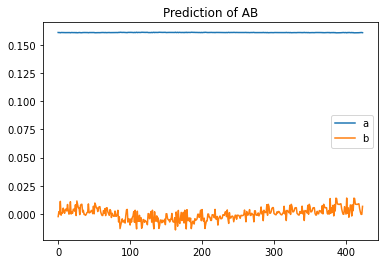

In [13]:
plt.plot(pred_pkg['a'], label='a')
plt.plot(pred_pkg['b'], label='b')
# 添加标题和标签
plt.title('Prediction of AB')
# plt.xlabel('Index of Model')
plt.legend()
plt.show()

In [14]:
df = pd.DataFrame(pred_pkg)
df = df.sort_values(by='date', ascending=True, kind='stable')
df = df.sort_values(by='insituid', ascending=True, kind='stable')
df = df.reset_index(drop=True)
print(df)
df.info()

          date smapid insituid         a         b      smap  ati_mean  \
0   2015-04-25     16        1  0.160839  0.010804  0.194087  0.049252   
1   2015-05-11     16        1  0.160874  0.008881  0.188378  0.050230   
2   2015-06-11     16        1  0.161031  0.000283  0.200379  0.042691   
3   2015-07-05     16        1  0.161171 -0.007383  0.287478  0.079474   
4   2015-07-06     16        1  0.161170 -0.007288  0.284187  0.059324   
..         ...    ...      ...       ...       ...       ...       ...   
419 2015-10-09     41        6  0.161003  0.001848  0.232548  0.038462   
420 2015-10-15     41        6  0.160985  0.002841  0.205021  0.034673   
421 2015-10-17     41        6  0.160986  0.002790  0.206502  0.039891   
422 2015-11-26     41        6  0.160882  0.008445  0.097272  0.028764   
423 2015-11-29     41        6  0.160883  0.008427  0.097768  0.028117   

       ati_sd  insitu_ati  insitu_sm   pred_sm  
0    0.013107    0.046995   0.434795 -0.016888  
1    0.016770

In [15]:
import random

start = 0
end = df.shape[0]-1
num_samples = 1

sample = np.random.randint(start, end+1, size=num_samples)
print(sample)

[107]


In [16]:
df.iloc[sample]

,date,smapid,insituid,a,b,smap,ati_mean,ati_sd,insitu_ati,insitu_sm,pred_sm
107,2015-08-14,2,2,0.16128,-0.013315,0.184943,0.053808,0.006767,0.051272,0.363704,-0.073744


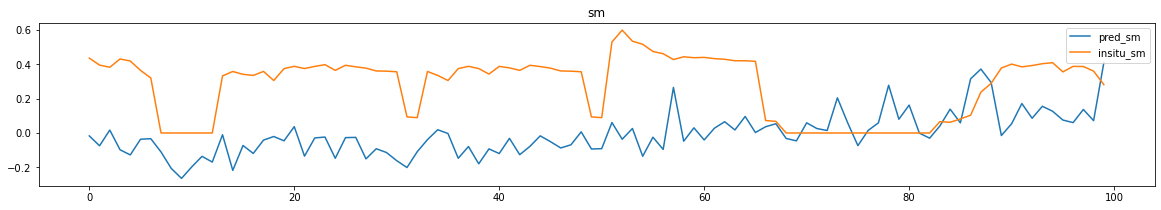

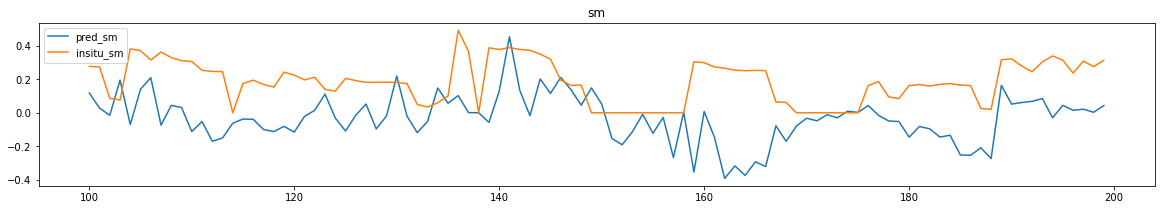

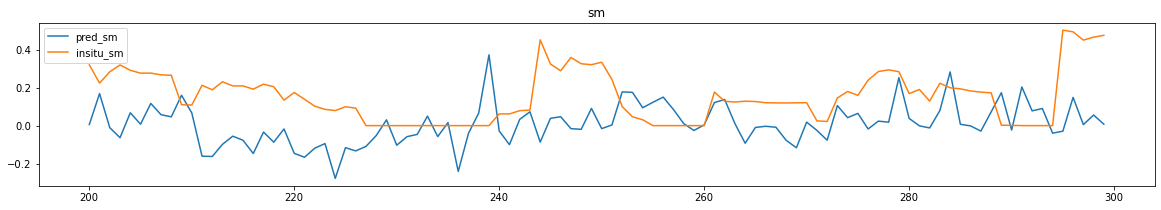

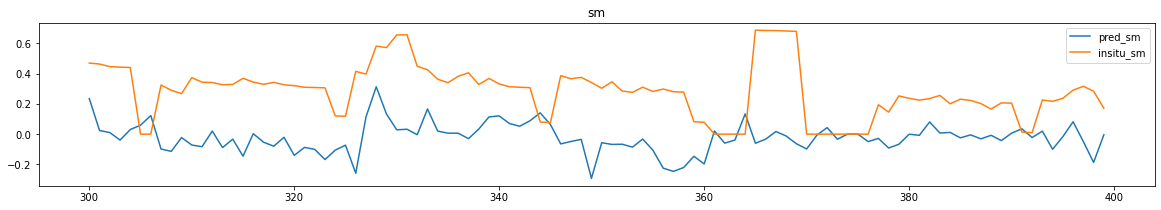

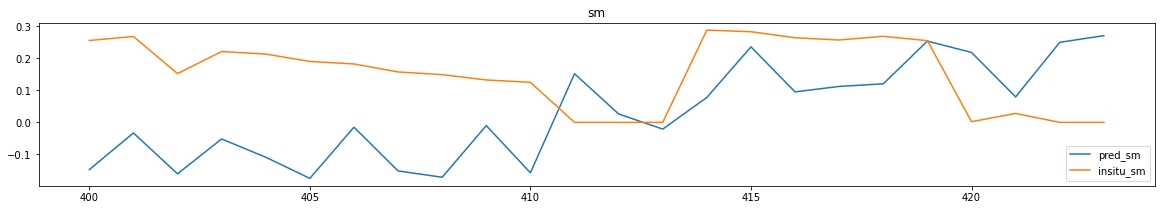

In [17]:
for i in range(int(df.shape[0]/100)+1):
    plt.figure(figsize=(20,3))
    plt.plot(df['pred_sm'].iloc[i*100:(i+1)*100], label='pred_sm')
    plt.plot(df['insitu_sm'].iloc[i*100:(i+1)*100], label='insitu_sm')
    # 添加标题和标签
    plt.title('sm')
    plt.legend()
    plt.savefig(os.path.join(config['model_save_dir'], 'sm for all waternet part '+str(i)), dpi=300, bbox_inches='tight')
    plt.show()

# 总体R和RMSE

In [18]:
corr = df['pred_sm'].corr(df['insitu_sm'])
print(corr)

0.021970942963401265


In [19]:
from sklearn.metrics import mean_squared_error

# calculate the mean squared error (MSE)
mse = mean_squared_error(df['insitu_sm'], df['pred_sm'])

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(rmse)

0.30697961087876996


# 站点R和RMSE

In [20]:
print(df['insituid'])

0      1
1      1
2      1
3      1
4      1
      ..
419    6
420    6
421    6
422    6
423    6
Name: insituid, Length: 424, dtype: object


In [21]:
insitu_grouped = df.groupby(['insituid'])

In [22]:
def calc_rmse(group):
    return np.sqrt(mean_squared_error(group['insitu_sm'], group['pred_sm']))

def calc_corr(group):
    print(group.size)
    return group.corr().iloc[0, 1]

In [23]:
insitu_rmse = insitu_grouped.apply(calc_rmse)
print(insitu_rmse)

insituid
1     0.353638
10    0.429910
11    0.417329
12    0.437406
16    0.102487
18    0.237637
2     0.334051
22    0.221489
25    0.234161
27    0.378449
30    0.225227
31    0.242790
32    0.287096
33    0.135839
35    0.257429
37    0.122994
4     0.165947
40    0.345342
42    0.390071
5     0.373594
52    0.424119
53    0.402708
54    0.215774
55    0.301942
6     0.159021
dtype: float64


(13, 11)
0.3536379698919938


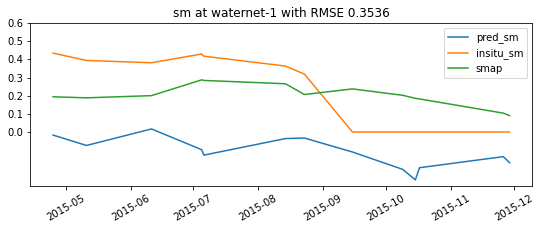

(20, 11)
0.4299096500246341


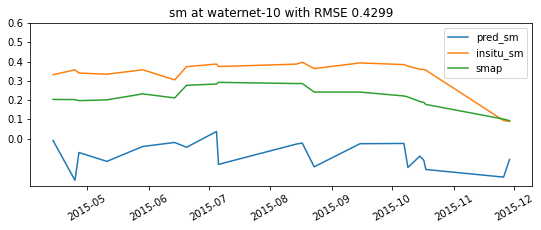

(18, 11)
0.41732909926379946


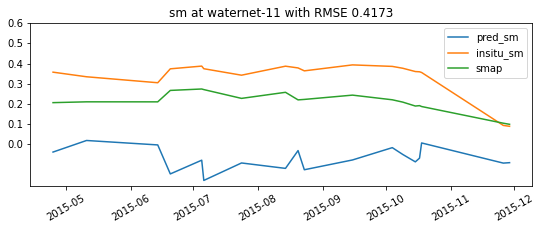

(17, 11)
0.43740609538751335


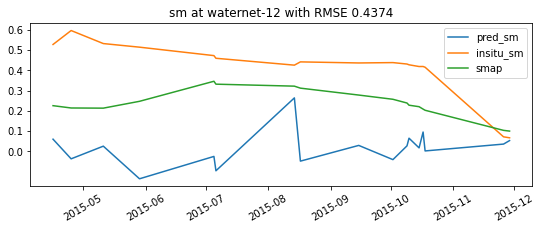

(17, 11)
0.10248681574475953


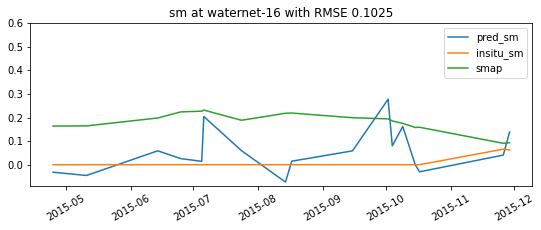

(19, 11)
0.23763712608234447


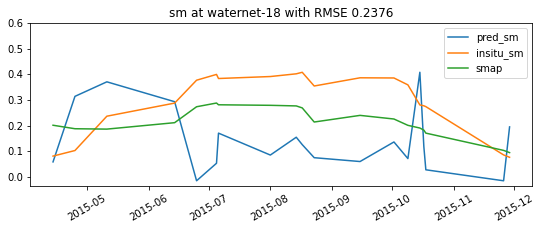

(11, 11)
0.334051075588507


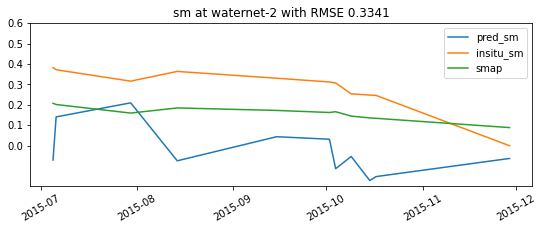

(19, 11)
0.22148856577760043


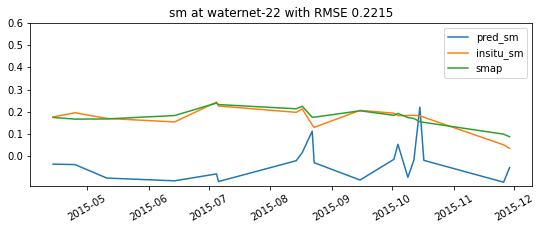

(16, 11)
0.23416140730713034


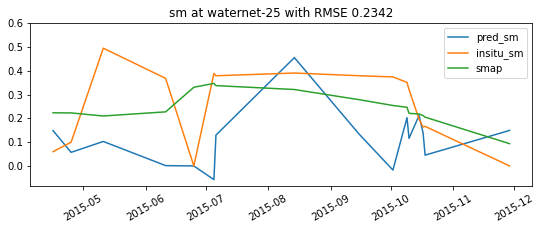

(19, 11)
0.37844900456517555


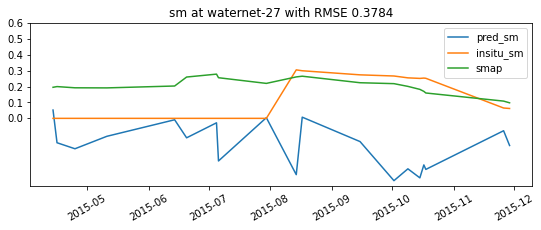

(20, 11)
0.22522657849750807


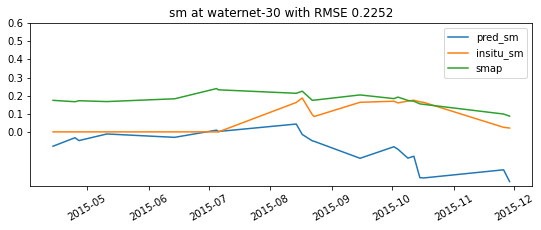

(22, 11)
0.24278961840479787


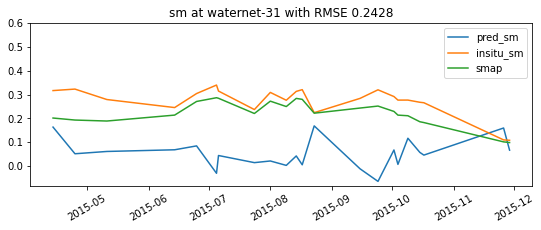

(16, 11)
0.2870963966245741


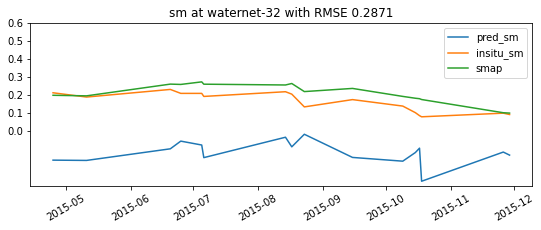

(15, 11)
0.13583911711616878


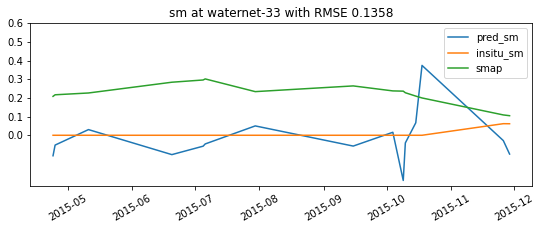

(15, 11)
0.257428990585897


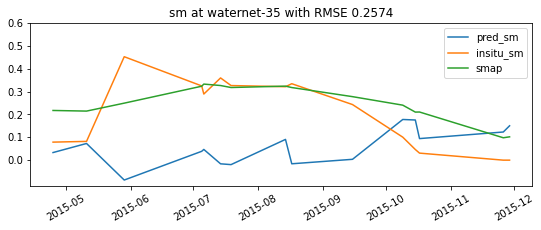

(16, 11)
0.12299412564431543


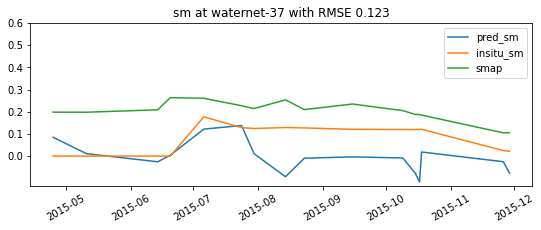

(18, 11)
0.16594673631599605


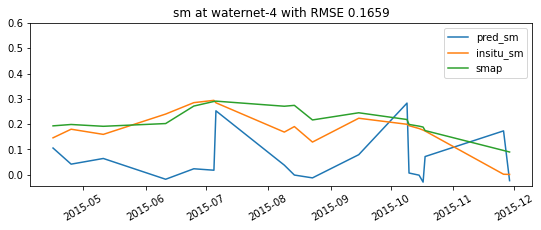

(16, 11)
0.34534214713136574


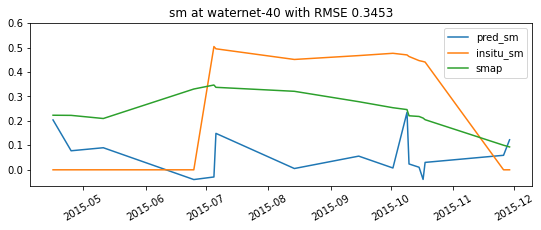

(19, 11)
0.39007146948215904


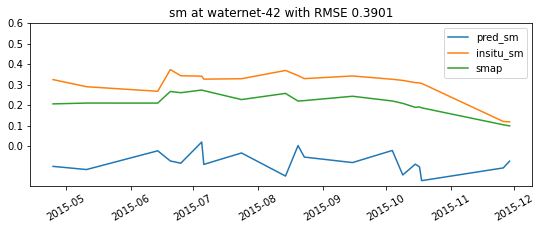

(20, 11)
0.3735935198432737


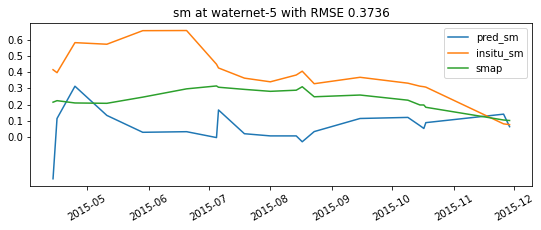

(15, 11)
0.4241188827068482


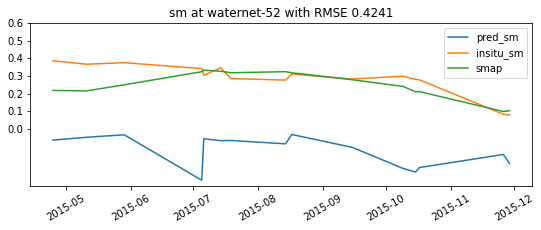

(16, 11)
0.4027080169262788


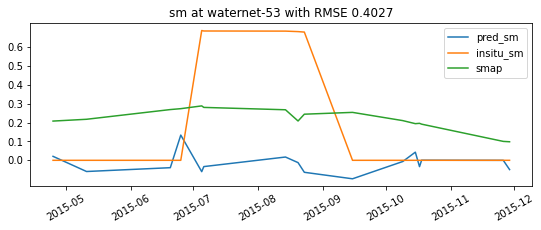

(16, 11)
0.21577354293022138


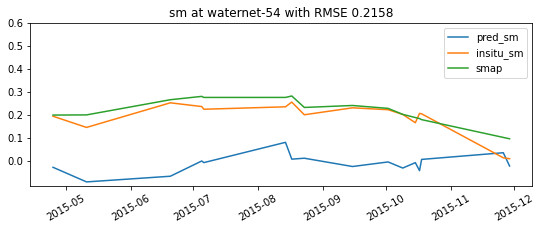

(18, 11)
0.30194164804668383


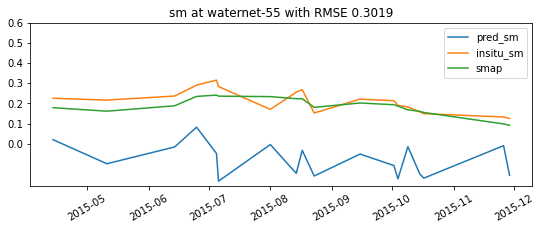

(13, 11)
0.1590209867491881


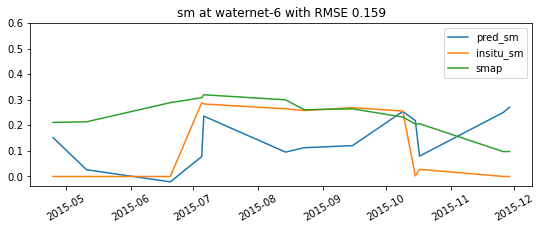

In [24]:
i = 0
for name, group in insitu_grouped:
    print(group.shape)
    print(insitu_rmse.iloc[i])
    plt.figure(figsize=(9,3))
    plt.plot(group['date'], group['pred_sm'], label='pred_sm')
    plt.plot(group['date'], group['insitu_sm'], label='insitu_sm')
    plt.plot(group['date'], group['smap'], label='smap')
    # 添加标题和标签
    plt.title('sm at waternet-'+ name + ' with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)))
    plt.legend()
    plt.xticks(rotation=30)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    plt.savefig(os.path.join(config['model_save_dir'], 'sm at waternet-'+ name + 'with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)) + '.png'), dpi=300, bbox_inches='tight')
    plt.show()
    i+=1

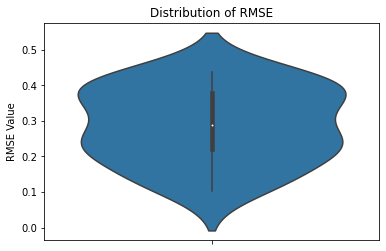

In [25]:
# 将数据转换为DataFrame格式
df_rmse = pd.DataFrame(insitu_rmse, columns=['RMSE'])

# 绘制小提琴图
sns.violinplot(y='RMSE', data=df_rmse, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of RMSE')
# plt.xlabel('Index of Model')
plt.ylabel('RMSE Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()

In [26]:
insitu_corr = insitu_grouped[['pred_sm', 'insitu_sm']].apply(calc_corr)
print(insitu_corr)

26
40
36
34
34
38
22
38
32
38
40
44
32
30
30
32
36
32
38
40
30
32
32
36
26
insituid
1     0.767901
10    0.364781
11    0.039480
12   -0.228202
16    0.129818
18   -0.191220
2     0.300214
22    0.061747
25    0.090012
27   -0.595204
30   -0.269932
31   -0.442828
32    0.361271
33   -0.135084
35   -0.805978
37    0.098117
4     0.061651
40   -0.232065
42    0.100148
5     0.031431
52    0.330261
53   -0.198029
54   -0.020047
55    0.301581
6     0.038515
dtype: float64


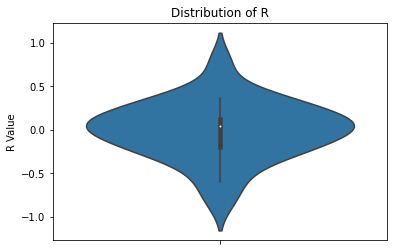

In [27]:
# 将数据转换为DataFrame格式
df_corr = pd.DataFrame(insitu_corr, columns=['R'])

# 绘制小提琴图
sns.violinplot(y='R', data=df_corr, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of R')
# plt.xlabel('Index of Model')
plt.ylabel('R Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()